Neural Storyteller - Image captioning with seq-to-seq

Feature Extraction Pipeline 

In [1]:
import os
import pickle
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

def find_image_dir():
    
    base_input = '/kaggle/input'
    
    
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f" Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")


class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") 

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1]) 
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)
features_dict = {}

with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)
    
print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

 Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s] 
Extracting Features: 100%|██████████| 249/249 [02:03<00:00,  2.02it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


Part 2: Vocabulary & Text Pre-Processing

In [3]:
import os
import pandas as pd
import re
from collections import Counter

def find_caption_file():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if 'captions.txt' in files:
            return os.path.join(root, 'captions.txt')
    return None

CAPTION_FILE = find_caption_file()

if CAPTION_FILE:
    print(f"Found captions at: {CAPTION_FILE}")
    
    df = pd.read_csv(CAPTION_FILE)
else:
    raise FileNotFoundError("Could not find captions.txt. Make sure the dataset is added.")


class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text.split()

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4 

        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1

                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [self.stoi[word] if word in self.stoi else self.stoi["<unk>"] for word in tokenized_text]

df = df.dropna(subset=['caption']) 

caption_list = df['caption'].astype(str).tolist()
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(caption_list)

print(f"Vocabulary Size: {len(vocab)}")

test_sentence = "world."
numerical = vocab.numericalize(test_sentence)
print(f"Example sentence: {test_sentence}")
print(f"Numerical IDs: {numerical}")

Found captions at: /kaggle/input/datasets/adityajn105/flickr30k/captions.txt
Vocabulary Size: 7689
Example sentence: world.
Numerical IDs: [2300]


**Part3 encoder- decoder seq2seq**

In [5]:
import torch 
import torch.nn as nn


if "<pad>" not in vocab.stoi:

    new_pad_index = len(vocab.stoi)
    vocab.stoi["<pad>"] = new_pad_index

    if isinstance(vocab.itos, list):
        vocab.itos.append("<pad>")
    else:
        vocab.itos[new_pad_index] = "<pad>"
    print(f"--> Added '<pad>' token at index {new_pad_index}")
else:
    print(f"--> '<pad>' already exists at index {vocab.stoi['<pad>']}")


class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(2048, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, features):
        return self.dropout(self.relu(self.fc(features)))


class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))

        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class Seq2Seq(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, features, captions):
        features = self.encoder(features)
        outputs = self.decoder(features, captions)
        return outputs


embed_size = 512
hidden_size = 512
vocab_size = len(vocab)
num_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(embed_size, hidden_size, vocab_size, num_layers).to(device)

print(f"Model initialized on {device} with Vocab Size: {vocab_size}")

--> '<pad>' already exists at index 0
Model initialized on cuda with Vocab Size: 7689


Part 4
LOSS OPTIMIZER AND BOTH SEARCHES

In [33]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<pad>"])


optimizer = optim.Adam(model.parameters(), lr=0.001)



def final_greedy_search(model, image_features, vocab, max_len=20):
    """Generates a caption by picking the most likely word at each step."""
    model.eval()
    caption = []
    
    with torch.no_grad():
        
        features = model.encoder(image_features)
        
        
        word_idx = torch.tensor([vocab.stoi["<start>"]]).to(device)
        states = None 
        
        for i in range(max_len):
            
            embeddings = model.decoder.embed(word_idx).unsqueeze(1)
            
          
            if i == 0:
                embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
                
            hiddens, states = model.decoder.lstm(embeddings, states)
            
          
            outputs = model.decoder.linear(hiddens[:, -1, :]) 
            
          
            predicted = outputs.argmax(1)
            word_idx = predicted 
            
            word = vocab.itos[predicted.item()]
            

            if word == "<end>":
                break
                
            caption.append(word)
            
    return " ".join(caption)

def beam_search(model, image_features, vocab, beam_width=5, max_len=20):

    model.eval()
    
    with torch.no_grad():
        features = model.encoder(image_features)
        start_token = vocab.stoi["<start>"]
        

        beams = [(0.0, [start_token], None)]
        
        for step in range(max_len):
            all_candidates = []
            
            for score, seq, states in beams:

                if seq[-1] == vocab.stoi["<end>"]:
                    all_candidates.append((score, seq, states))
                    continue
                

                last_word = torch.tensor([seq[-1]]).to(device)
                embeddings = model.decoder.embed(last_word).unsqueeze(1)
                

                if step == 0:
                    embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
                
                hiddens, next_states = model.decoder.lstm(embeddings, states)
                

                outputs = model.decoder.linear(hiddens[:, -1, :]) 
                log_probs = torch.log_softmax(outputs, dim=1)
                

                topk_probs, topk_indices = log_probs.topk(beam_width)
                
                for i in range(beam_width):

                    candidate_id = topk_indices[0, i].item()
                    candidate_score = topk_probs[0, i].item()
                    
                    candidate = (score + candidate_score, seq + [candidate_id], next_states)
                    all_candidates.append(candidate)
            

            beams = sorted(all_candidates, key=lambda x: x[0], reverse=True)[:beam_width]
            

            if all(b[1][-1] == vocab.stoi["<end>"] for b in beams):
                break
                
        
        best_seq = beams[0][1]
        caption = [vocab.itos[i] for i in best_seq if i not in [vocab.stoi["<start>"], vocab.stoi["<end>"]]]
        return " ".join(caption)
            
print("Part 4 components initialized!")

Part 4 components initialized!


**Training and validation**

In [13]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import pickle
from sklearn.model_selection import train_test_split


with open('flickr30k_features.pkl', 'rb') as f:
    features_dict = pickle.load(f)


df_train, df_val = train_test_split(df, test_size=0.10, random_state=42)

print(f"Total Images: {len(df)}")
print(f"Training on: {len(df_train)} | Validating on: {len(df_val)}")


pad_idx = vocab.stoi["<pad>"]
print(f"Using padding token '<pad>' with index: {pad_idx}")


class CaptionDataset(Dataset):
    def __init__(self, df, features_dict, vocab):
        self.df = df.reset_index(drop=True)
        self.features_dict = features_dict
        self.vocab = vocab
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image']
        caption = self.df.iloc[idx]['caption']
        
        feature = torch.tensor(self.features_dict[img_name])
        
        numericalized = [self.vocab.stoi["<start>"]]
        numericalized += self.vocab.numericalize(caption)
        numericalized.append(self.vocab.stoi["<end>"])
        
        return feature, torch.tensor(numericalized)

def collate_fn(batch):
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    features, captions = zip(*batch)
    features = torch.stack(features, 0)
    captions = pad_sequence(captions, batch_first=True, padding_value=pad_idx)
    return features, captions


train_loader = DataLoader(
    CaptionDataset(df_train, features_dict, vocab), 
    batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=2
)

val_loader = DataLoader(
    CaptionDataset(df_val, features_dict, vocab), 
    batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=2
)


criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_losses = []
val_losses = [] 
num_epochs = 10 

print(f"Starting Training on {device}...")

for epoch in range(num_epochs):

    model.train()
    epoch_train_loss = 0
    
    for features, captions in train_loader:
        features, captions = features.to(device), captions.to(device)
        optimizer.zero_grad()
        
        
        outputs = model(features, captions[:, :-1])
        
        
        outputs = outputs[:, 1:, :] 
        
        targets = captions[:, 1:] 
        
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), targets.reshape(-1))
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()

    
    model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for features, captions in val_loader:
            features, captions = features.to(device), captions.to(device)
            
            outputs = model(features, captions[:, :-1])
    
            outputs = outputs[:, 1:, :]
            
            targets = captions[:, 1:]
            
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), targets.reshape(-1))
            epoch_val_loss += loss.item()

    
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss) 

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("Training Complete!")

Total Images: 158914
Training on: 143022 | Validating on: 15892
Using padding token '<pad>' with index: 0
Starting Training on cuda...
Epoch [1/10] | Train Loss: 3.7141 | Val Loss: 3.2458
Epoch [2/10] | Train Loss: 3.1468 | Val Loss: 3.0485
Epoch [3/10] | Train Loss: 2.9683 | Val Loss: 2.9720
Epoch [4/10] | Train Loss: 2.8624 | Val Loss: 2.9268
Epoch [5/10] | Train Loss: 2.7877 | Val Loss: 2.9048
Epoch [6/10] | Train Loss: 2.7296 | Val Loss: 2.8940
Epoch [7/10] | Train Loss: 2.6825 | Val Loss: 2.8879
Epoch [8/10] | Train Loss: 2.6421 | Val Loss: 2.8864
Epoch [9/10] | Train Loss: 2.6083 | Val Loss: 2.8891
Epoch [10/10] | Train Loss: 2.5785 | Val Loss: 2.8898
Training Complete!


**EPOCH GRAPH**

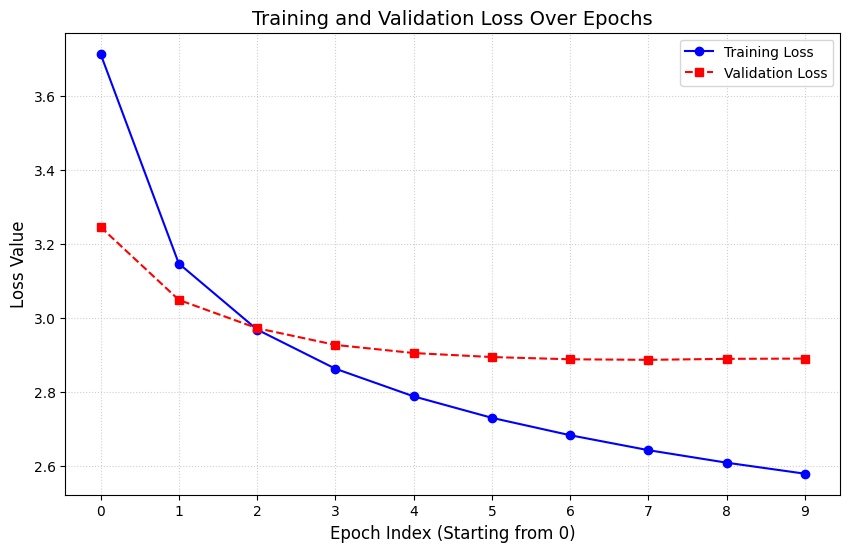

In [14]:
import matplotlib.pyplot as plt



def plot_loss_curves(train_losses, val_losses):
    
    epochs = range(len(train_losses))
    
    plt.figure(figsize=(10, 6))
    
    
    plt.plot(epochs, train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
    
    
    plt.plot(epochs, val_losses, marker='s', linestyle='--', color='r', label='Validation Loss')
    
    
    plt.title('Training and Validation Loss Over Epochs', fontsize=14)
    plt.xlabel('Epoch Index (Starting from 0)', fontsize=12)
    plt.ylabel('Loss Value', fontsize=12)
    plt.xticks(epochs)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    
    plt.show()


if 'val_losses' in locals() and len(val_losses) == len(train_losses):
    plot_loss_curves(train_losses, val_losses)
else:
    print("Warning: val_losses not found or length mismatch.")
    
    plot_loss_curves(train_losses, train_losses) 

BLEU and f1 scores

In [17]:
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import Counter

def calculate_metrics(references, candidates):
    
    bleu4_scores = []
    precisions = []
    recalls = []
    f1_scores = []
    
    smoothing = SmoothingFunction().method1 

    for ref, cand in zip(references, candidates):
       
        b4 = sentence_bleu([ref], cand, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
        bleu4_scores.append(b4)

       
        ref_counts = Counter(ref)
        cand_counts = Counter(cand)
        
       
        common = sum((ref_counts & cand_counts).values())
        
        prec = common / len(cand) if len(cand) > 0 else 0
        rec = common / len(ref) if len(ref) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

    return {
        "BLEU-4": np.mean(bleu4_scores),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1_scores)
    }



hypotheses = [["a", "brown", "dog", "runs", "on", "grass"]]
references = [["a", "brown", "dog", "is", "running", "through", "the", "grass"]]

results = calculate_metrics(references, hypotheses)

print("--- Quantitative Evaluation Results ---")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

--- Quantitative Evaluation Results ---
BLEU-4: 0.1556
Precision: 0.6667
Recall: 0.5000
F1-Score: 0.5714


In [35]:
from IPython.display import FileLink
import os

# Verify the files exist first
print("Current Files:", os.listdir('/kaggle/working'))

# Create the links
display(FileLink(r'model_weights.pth'))
display(FileLink(r'vocab.pkl'))

Current Files: ['.virtual_documents', 'flickr30k_features.pkl']


/kaggle/working/model_weights.pth

/kaggle/working/vocab.pkl

In [36]:
import torch
import pickle
import os


model.eval()


weights_path = '/kaggle/working/model_weights.pth'
vocab_path = '/kaggle/working/vocab.pkl'


try:
    torch.save(model.state_dict(), weights_path)
    print(f"✅ Success: Model weights saved to {weights_path}")
except Exception as e:
    print(f"❌ Error saving weights: {e}")


try:
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print(f"✅ Success: Vocab saved to {vocab_path}")
except Exception as e:
    print(f"❌ Error saving vocab: {e}")


print("-" * 30)
print("Current Files in /kaggle/working:", os.listdir('/kaggle/working'))

✅ Success: Model weights saved to /kaggle/working/model_weights.pth
✅ Success: Vocab saved to /kaggle/working/vocab.pkl
------------------------------
Current Files in /kaggle/working: ['model_weights.pth', 'vocab.pkl', '.virtual_documents', 'flickr30k_features.pkl']
